In [1]:
# Execute this first 
#
#  * Trigger notebook styling
#  * Save current directory 
%run src/init_notebooks.py
import os
rdir = os.getcwd()

# Molecular dynamics simulation of a small protein using GROMACS 

    authors  : Dmitry Morozov (based on a Gerrit Groenhof tutorial see http://wwwuser.gwdg.de/~ggroenh/EMBO2004/html/introduction.html ).    
    goal     : learn how to explore energy surface of reaction using GROMACS-CP2K QM/MM interface 
    time     : 60 minutes
    software : GROMACS 2022 with CP2K 9.0, python modules: numpy, matplotlib, nglviewer, md_traj, pandas) 
    optional software: visualization software VMD, Xmgrace plotting tool

# Preparations to run this notebook

In [6]:
# Change to the data directory
# Note that executing this command twice will result in an error you can ignore
%cd data

[Errno 2] No such file or directory: 'data'
/mnt/i/Presentations/CSC-AWH-tutorial-2022/tutorial/data


# Input for a simulation

In this tutorial we are going to study a catalytic antibody that catalyzes the Diels Alder cyclo-addition reaction shown here. The x-ray structure of the analogue-antibody complex has been determined by Xu et al. (Science 1999, 286, 2345-2348) and is available from the protein databank [1C1E](https://www.rcsb.org/structure/1C1E).

In [3]:
import nglview as ng
view = ng.show_structure_file(rdir + "/reference-data/1c1e.pdb")
view.center(selection='ENH')
view

# click and drag to rotate, zoom with your mouseweel 
# for more infor on this viewer have a look at https://github.com/nglviewer/nglview

NGLWidget()

It should be noted that structure contains analogue of the substrate. Real substrate, which will be studied in the tutorial, is looking like that: 

In [11]:
import nglview as ng
view = ng.show_structure_file(rdir + "/reference-data/dat.pdb")
view

NGLWidget()

# Linear transit scan of the Diels-Alder reaction potential energy surface *in vacuo*

Once you've had a look at the system, you are going to want to study it in the vacuum. In the Linear Transit method (also known as Relaxed Surface scan)) a coordinate is choosen along which the reactants are transformed into product. This so called reaction coordinate is varied linearly while all other degrees of freedom are minimized (relaxed). Choosing such reaction coordinate requires some intuition and understanding of the process studied, but is in general easier to chose than a reasonable guess geometry. The concept of the reaction coordinate is best explained by an example. In case of a Diels-Alder cyclo-addition, a good reaction coordinate would be the distance between the two atom pairs that are forming the two new bonds upon reaction:
![img](files/images/react-coord.gif)

Once the reaction coordinate is choosen, we slowly progress along that coordinate, while minimizing all other degrees of freedom. In practice, the reaction coordinate is constrained or restrained at a number of distances. Afterwards, the potential energy is plotted as a function the reaction coordinate. The maximum of this curve is the transition state and the minima are the reactant and product states.

Here we will use the GROMACS QM/MM features to perform a Linear Transit calculation of the Diels-Alder cyclo-addition reaction foor substrate shown above. The -R group, which was missing in the x-ray model and ignored in the previous part of the tutorial, will now be taken into account. Because this group is unlikely to have a large effect on the reaction, we will describe it at the MM level in our model:
![img](files/images/qmmm_vac_small.gif)

The QM/MM division splits the systems along a chemical bond. Therefore, we need to cap the QM subsystem with a so-called link atom. This link atom is present as a hydrogen atom only at the QM calculation step within CP2K. It is not physically present in the GROMACS system, but the forces on it, that are computed in the QM step, are distributed over the two atoms of the bond. The broken bond length itself is still accounted with MM forecfield during the simulation.

In [7]:
# Change to the DA-opt directory
# Note that executing this command twice will result in an error you can ignore
%cd DA-opt

/mnt/i/Presentations/CSC-AWH-tutorial-2022/tutorial/data/DA-opt


### Specifying QM/MM simulation setup

Once we have decided which atoms should be treated by a QM method we add these atoms to the index file. We can either use the make_ndx program, or hack the atoms into the index.ndx file ourselves. The index file we will use in this tutorial is found here: 

In [13]:
!cat index.ndx

[ System ]
   1    2    3    4    5    6    7    8    9   10   11   12   13   14   15
  16   17   18   19   20   21   22   23   24   25   26   27   28   29   30
  31   32   33   34   35   36   37   38
[ Other ]
   1    2    3    4    5    6    7    8    9   10   11   12   13   14   15
  16   17   18   19   20   21   22   23   24   25   26   27   28   29   30
  31   32   33   34   35   36   37   38
[ DAT ]
   1    2    3    4    5    6    7    8    9   10   11   12   13   14   15
  16   17   18   19   20   21   22   23   24   25   26   27   28   29   30
  31   32   33   34   35   36   37   38
[ QMatoms ]
   1    2    3    4    5    6    7    8    9   10   11   12   13   14   15
  16   17   18   19   20   21   22   23
[ group1 ]
  14   16
[ group2 ]
   1    7


Atoms that will be treated at the QM level are defined in **[ QMatoms ]** group.  
Next we should request GROMACS to perform QM/MM simulation, that is done by specifying several parameters in the *.mdp* file:

In [14]:
!cat LT.mdp

title                    = relaxed-surface

integrator               = steep

tinit                    = 0
dt                       = 0.002
nsteps                   = 100

nstcomm                  = 1
comm_grps                = system

emtol                    = 100.0
emstep                   = 0.0001

nstxout                  = 1
nstvout                  = 1
nstfout                  = 1
nstlog                   = 1
nstenergy                = 1
nstxtcout                = 1
xtc-precision            = 1000
xtc_grps                 = system
energy_grps              = 

nstlist                  = 10
ns_type                  = grid
pbc                      = xyz
rlist                    = 1.0
coulombtype              = PME
rcoulomb-switch          = 1.0
rcoulomb                 = 1.6

vdwtype                  = Cut-off
rvdw-switch              = 0
rvdw                     = 1.6
DispCorr                 = No

constraints              = none

qmmm-cp2k-active         = true
qmmm-cp2k-qmgroup 

- **qmmm-cp2k-active         = true** - activates QM/MM MDModule
- **qmmm-cp2k-qmgroup        = QMatoms** - specifies group of atoms, that should be treated with QM
- **qmmm-cp2k-qmmethod       = PBE** - specifies QM method to be used
- **qmmm-cp2k-qmcharge       = 0** - total charge os QM system
- **qmmm-cp2k-qmmultiplicity = 1** - total multiplicity of QM system (singlet here)


In all other points this is typical minimization run using steepest descent intergator

Now take a look into the topology of substrate:

In [15]:
!cat dat.itp

; dat_GMX.itp created by acpype (v: 2021-02-05T22:15:50CET) on Wed Jan 19 21:43:58 2022

[ atomtypes ]
;name   bond_type     mass     charge   ptype   sigma         epsilon       Amb
 c3       6           0.00000  0.00000   A     3.39967e-01   4.57730e-01 ; 1.91  0.1094
 cl       17          0.00000  0.00000   A     3.47094e-01   1.10876e+00 ; 1.95  0.2650
 c2       6           0.00000  0.00000   A     3.39967e-01   3.59824e-01 ; 1.91  0.0860
 s6       16          0.00000  0.00000   A     3.56359e-01   1.04600e+00 ; 2.00  0.2500
 o        8           0.00000  0.00000   A     2.95992e-01   8.78640e-01 ; 1.66  0.2100
 c        6           0.00000  0.00000   A     3.39967e-01   3.59824e-01 ; 1.91  0.0860
 hc       1           0.00000  0.00000   A     2.64953e-01   6.56888e-02 ; 1.49  0.0157
 n        7           0.00000  0.00000   A     3.25000e-01   7.11280e-01 ; 1.82  0.1700
 h1       1           0.00000  0.00000   A     2.47135e-01   6.56888e-02 ; 1.39  0.0157
 
[ moleculetype ]
;name 

At the end of file two constraint have been specified like that:
```
[ constraints ]
     1     14      1  @LEN@  
     7     16      1  @LEN@  
```
They will represent our reaction coordinate and `@LEN@` will be replaced with the specific number at each individual minimization run during the simulation.

### Running PES scan simulation

Lets also look into the simulation batch script, that will be submited for computation:

In [16]:
!cat run-surface.sh

It will loop over the reaction coordiante distance replacing `@LEN` using `sed` in the topology and performing simulation with `srun` command in separate directory. After the simulation it gathers data about final energy and reaction coordinate value into the *rsurf.xvg* file. Now lets submit our jobs to the cluster:

In [17]:
! sbatch run-surface.sh

/bin/bash: sbatch: command not found


You can always check status of your job with `squeue` command:

In [18]:
!squeue --user=`whoami`

/bin/bash: squeue: command not found


Wait until that job finish before going to the next part of the tutorial.

As the job takes more time than 10 minutes specified in the batch script we have prepared sample *rsurf.xvg* file with profile. We could plot data from that using Python:

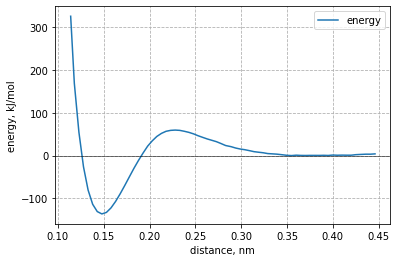

In [72]:
import pandas as pd
df = pd.read_csv(rdir + "/reference-data/DA-opt/rsurf.xvg", sep='\s+', header=None, names=['distance','energy'])
mine = min(df[['energy']].to_numpy()[20:])
df['energy'] -= mine
ax = df.plot('distance',xlabel='distance, nm', ylabel='energy, kJ/mol', legend=False)
ax.grid(True, which='both', linestyle='--')
ax.axhline(y=0, color='k', linewidth=0.5)

And also calculate TS and Products energy with respect to reagents:

In [45]:
print(f"TS Energy = {df['energy'].loc[10:].max():.3f} kJ/mol at distance {df['distance'][df['energy'].loc[10:].idxmax()]:.3f} nm")
print(f"Products energy = {df['energy'].min():.3f} kJ/mol at distance {df['distance'][df['energy'].idxmin()]:.3f} nm")

TS Energy = 59.613 kJ/mol at distance 0.228 nm
Products energy = -136.492 kJ/mol at distance 0.148 nm


There is also an animation of the optimized reaction pathway:

In [68]:
import nglview as ng 
import mdtraj as md
traj = md.load(rdir + "/reference-data/DA-opt/traj_opt.pdb", top=rdir + "/reference-data/dat.pdb")
view = ng.show_mdtraj(traj)
pair = [ [ 1, 7 ] ]
view.add_distance(atom_pair=[["@13","@0"]], label_visible=True, label_color=0x0)
view.add_distance(atom_pair=[["@15","@6"]], label_visible=True, label_color=0x0)
view

NGLWidget(max_frame=66)

# Free-energy profile simulation: umbrella sampling 

To account for the entropy effect on the reaction profile one typically would like to perform free-energy profile simulation instead of a normal. One of the most wide-spread methods nowadays is called Umbrella Sampling simulations:
![img](files/images/umbrella-sampling.png)

It requires to perform a set of biased simulations of your system in a presence of external potential (usually harmonic) that will drive sampling of the whole reaction coordinate space by pulling system towards particular point for each individual simulation. It is important that:
1. There is sufficient overlap between coordinate distributions of individual windows (like show on the figure above)
2. Distributions in each window should be as close to gaussian as possible

GROMACS has capabilities to perform such simulations using pulling module in combination with **`gmx wham`** command-line utility. Lets perform that kind of free-energy simulation for the same Diels-Alder reaction as studied above.


In [8]:
#Go to DA-us directory
%cd ../DA-us

/mnt/i/Presentations/CSC-AWH-tutorial-2022/tutorial/data/DA-us


Here is the same index file as used in previous exercise:

In [10]:
!cat index.ndx

[ System ]
   1    2    3    4    5    6    7    8    9   10   11   12   13   14   15
  16   17   18   19   20   21   22   23   24   25   26   27   28   29   30
  31   32   33   34   35   36   37   38
[ Other ]
   1    2    3    4    5    6    7    8    9   10   11   12   13   14   15
  16   17   18   19   20   21   22   23   24   25   26   27   28   29   30
  31   32   33   34   35   36   37   38
[ DAT ]
   1    2    3    4    5    6    7    8    9   10   11   12   13   14   15
  16   17   18   19   20   21   22   23   24   25   26   27   28   29   30
  31   32   33   34   35   36   37   38
[ QMatoms ]
   1    2    3    4    5    6    7    8    9   10   11   12   13   14   15
  16   17   18   19   20   21   22   23
[ group1 ]
  14   16
[ group2 ]
   1    7


And topology of the molecule that is the same except of removed `[ constraints ]` section (we will use harmonic potential to bias the system):

In [11]:
!cat dat.itp

; dat_GMX.itp created by acpype (v: 2021-02-05T22:15:50CET) on Wed Jan 19 21:43:58 2022

[ atomtypes ]
;name   bond_type     mass     charge   ptype   sigma         epsilon       Amb
 c3       6           0.00000  0.00000   A     3.39967e-01   4.57730e-01 ; 1.91  0.1094
 cl       17          0.00000  0.00000   A     3.47094e-01   1.10876e+00 ; 1.95  0.2650
 c2       6           0.00000  0.00000   A     3.39967e-01   3.59824e-01 ; 1.91  0.0860
 s6       16          0.00000  0.00000   A     3.56359e-01   1.04600e+00 ; 2.00  0.2500
 o        8           0.00000  0.00000   A     2.95992e-01   8.78640e-01 ; 1.66  0.2100
 c        6           0.00000  0.00000   A     3.39967e-01   3.59824e-01 ; 1.91  0.0860
 hc       1           0.00000  0.00000   A     2.64953e-01   6.56888e-02 ; 1.49  0.0157
 n        7           0.00000  0.00000   A     3.25000e-01   7.11280e-01 ; 1.82  0.1700
 h1       1           0.00000  0.00000   A     2.47135e-01   6.56888e-02 ; 1.39  0.0157
 
[ moleculetype ]
;name 

Now lets look into the *qmmm-umbrella.mdp* file:

In [13]:
!cat qmmm-umbrella.mdp

title                    = QMMM-umbrella

integrator               = md

tinit                    = 0
dt                       = 0.001
nsteps                   = 100

nstcomm                  = 1
comm_grps                = system

nstxout                  = 100
nstvout                  = 100
nstfout                  = 100
nstlog                   = 1
nstenergy                = 1
nstxtcout                = 100
xtc-precision            = 1000
xtc_grps                 = system
nstcalcenergy            = 1
energy_grps              = 

cutoff-scheme            = verlet
nstlist                  = 10
pbc                      = xyz
periodic-molecules       = no
verlet-buffer-tolerance  = 0.005
rlist                    = 1.2

coulombtype              = PME
coulomb-modifier         = Potential-shift-Verlet
rcoulomb-switch          = 1.0
rcoulomb                 = 1.2
vdwtype                  = Cut-off
vdw-modifier             = Force-switch
rvdw-switch              = 1.0
rvdw                    

Please check `pull` section, it contains parameters of harmonic potential, which we will apply for our system. We will use pre-equilibrated gro file as a starting structure. All that starting point have been created by pulling the system through the whole coordinate space from 0.15 to 0.53 nm over 10 ps with QM/MM simulation and extracting 21 equally spaced frames from that trajectory.

In [6]:
!cp eq_gro/md_eq10.gro conf.gro

Now lets generate *topol.tpr* file:

In [7]:
!gmx_cp2k grompp -f qmmm-umbrella.mdp -p topol.top -c conf.gro -n index.ndx -o md-us10.tpr -maxwarn 10

        :-) GROMACS - gmx grompp, 2022-beta1-dev-20211011-6062d391a3 (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
        Gaurav Garg            Gilles Gouaillardet             Alan Gray         
      Gerrit Groenhof             Anca Hamuraru            Vincent Hindriksen    
      M. Eric Irrgang            Aleksei Iupinov           Christoph Junghans    
         Joe Jordan            Dimitrios Karkoulis            Peter Kasson       
         Jiri Kraus              Carsten Kutzner              Per Larsson        
      Justin A. Lemkul            Viveca Lindahl            Magnus Lundborg      
       Erik Marklund               Pascal Merz         

And submit it for simulation:

In [ ]:
!sbatch run-us.sh

Now you will need to wait for 10-15 minutes until simulation is finished. You can check status by executing the following cell:

In [15]:
!squeue --user=`whoami`

/bin/bash: squeue: command not found


After that, lets add data from your simulation to another 20 simulations of frames in the *profile100fs* directory. Here we have pre-computed them for you, but typically you would need to perform all of them one-by-one or in parallel, depending on your resources.

In [8]:
!cp pullx.xvg profile100fs/pullx10.xvg
!cp md-us10.tpr profile100fs/md-us10.tpr


cp: cannot stat 'pullx.xvg': No such file or directory


Then go to profile100fs directory and perform integration of the profile using `gmx wham` tool::

In [9]:
%cd profile100fs
!ls pullx* >pullx-files.dat
!ls *.tpr  >tpr-files.dat
!gmx_cp2k wham -it tpr-files.dat -ix pullx-files.dat -o -hist -unit kJ -min 0.14 -max 0.45 -b 0 -bins 20
%cd ..

/mnt/i/Presentations/CSC-AWH-tutorial-2022/tutorial/data/DA-us/profile100fs
         :-) GROMACS - gmx wham, 2022-beta1-dev-20211011-6062d391a3 (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
        Gaurav Garg            Gilles Gouaillardet             Alan Gray         
      Gerrit Groenhof             Anca Hamuraru            Vincent Hindriksen    
      M. Eric Irrgang            Aleksei Iupinov           Christoph Junghans    
         Joe Jordan            Dimitrios Karkoulis            Peter Kasson       
         Jiri Kraus              Carsten Kutzner              Per Larsson        
      Justin A. Lemkul            Viveca Lindahl            Ma

Lets plot the resulting profile:

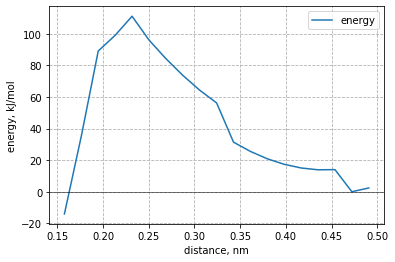

In [12]:
import pandas as pd
df = pd.read_csv("./profile100fs/profile.xvg", sep='\s+', header=17, names=['distance','energy'])
mine = min(df[['energy']].to_numpy()[5:])
df['energy'] -= mine
ax = df.plot('distance',xlabel='distance, nm', ylabel='energy, kJ/mol', legend=False)
ax.grid(True, which='both', linestyle='--')
ax.axhline(y=0, color='k', linewidth=0.5)

And coordinate distribution in each umbrellla window:

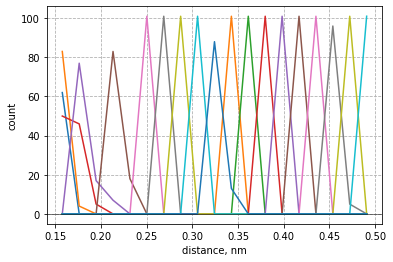

In [33]:
import pandas as pd
df = pd.read_csv("./profile100fs/histo.xvg", sep='\s+', header=17)
ax = df.plot(x=0, xlabel='distance, nm', ylabel='count', legend=False)
ax.grid(True, which='both', linestyle='--')
ax.axhline(y=0, color='k', linewidth=0.5)

They look really bad, especially if you compare profile with the one obtained with simple minimizations! That why umbrella sampling is very dependent on the understanding of method. For example, if you look into profile and histograms generated from 10 ps (10000 steps) trajectories it will look much better:

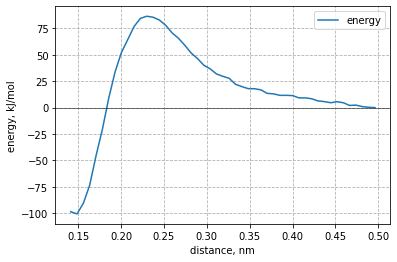

In [32]:
import pandas as pd
df = pd.read_csv(rdir + "/reference-data/DA-us/profile10ps.xvg", sep='\s+', header=17, names=['distance','energy'])
mine = min(df[['energy']].to_numpy()[10:])
df['energy'] -= mine
ax = df.plot('distance',xlabel='distance, nm', ylabel='energy, kJ/mol', legend=False)
ax.grid(True, which='both', linestyle='--')
ax.axhline(y=0, color='k', linewidth=0.5)


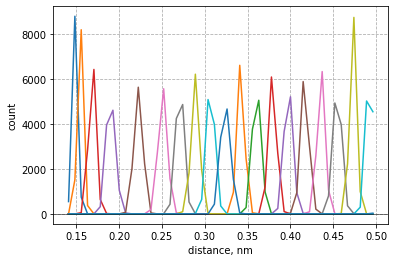

In [34]:
df = pd.read_csv(rdir + "/reference-data/DA-us/histo10ps.xvg", sep='\s+', header=17)
ax = df.plot(x=0, xlabel='distance, nm', ylabel='count', legend=False)
ax.grid(True, which='both', linestyle='--')
ax.axhline(y=0, color='k', linewidth=0.5)

And finally lets compare all energy profiles obtained so far:

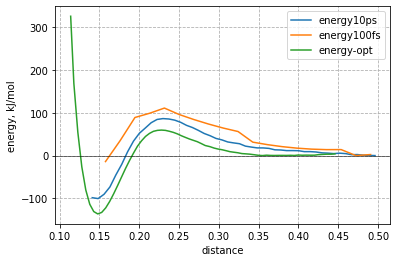

In [35]:
import pandas as pd
df = pd.read_csv(rdir + "/reference-data/DA-us/profile10ps.xvg", sep='\s+', header=17, names=['distance','energy10ps'])
mine = min(df[['energy10ps']].to_numpy()[10:])
df['energy10ps'] -= mine
ax = df.plot('distance',xlabel='distance, nm', ylabel='energy, kJ/mol')

df100fs = pd.read_csv("./profile100fs/profile.xvg", sep='\s+', header=17, names=['distance','energy100fs'])
mine = min(df100fs[['energy100fs']].to_numpy()[5:])
df100fs['energy100fs'] -= mine
df100fs.plot('distance', ax=ax)

dfopt = pd.read_csv(rdir + "/reference-data/DA-opt/rsurf.xvg", sep='\s+', header=None, names=['distance','energy-opt'])
mine = min(dfopt[['energy-opt']].to_numpy()[20:])
dfopt['energy-opt'] -= mine
dfopt.plot('distance', ax=ax)

ax.grid(True, which='both', linestyle='--')
ax.axhline(y=0, color='k', linewidth=0.5)

As a final remark for this part: free-energy profile could differ from the potential energy surface quiet a lot. However, to sample free-energy properly, a lot computing resources needed. To make 10 ps profile in total 210 ps of simulations (21 frames * 10 ps) have been performed. That took around 252 ode/hours (10080 CPU/hours). In addition, user need to decide on the quality of sampling and when to stop simulations.

# Free-energy profile simulation: AWH

In this part we will apply more advanced enhanced simulation technique Accelerated Weight Histogram (AWH), which to a large extent, helps with sampling issues by applying bias, that changes in time with more data gathered. The AWH calculates the PMF along a reaction coordinate by adding an adaptively determined biasing potential. AWH flattens free energy barriers along the reaction coordinate by applying a history-dependent potential to the system that “fills up” free energy minima. This is similar in spirit to other adaptive biasing potential methods, e.g. adaptive biasing force (ABF) and metadynamics methods.

In [9]:
#Go to DA-awh directory
%cd ../DA-awh

/mnt/i/Presentations/CSC-AWH-tutorial-2022/tutorial/data/DA-awh


Check *qmmm-awh.mdp* file, especially `awh` and `pull` sections parameters:

In [11]:
!cat qmmm-awh.mdp

title                    = QMMM-awh

integrator               = md

tinit                    = 0
dt                       = 0.001
nsteps                   = 100

nstcomm                  = 1
comm-grps                = system

nstxout                  = 100
nstvout                  = 100
nstfout                  = 100
nstlog                   = 1
nstenergy                = 1
nstxtcout                = 100
xtc-precision            = 1000
xtc-grps                 = system
nstcalcenergy            = 1
energy-grps              = 

cutoff-scheme            = verlet
nstlist                  = 10
pbc                      = xyz
periodic-molecules       = no
verlet-buffer-tolerance  = 0.005
rlist                    = 1.2

coulombtype              = PME
coulomb-modifier         = Potential-shift-Verlet
rcoulomb-switch          = 1.0
rcoulomb                 = 1.2
vdwtype                  = Cut-off
vdw-modifier             = Force-switch
rvdw-switch              = 1.0
rvdw                     = 1.

Here is some ideas how you should chose AWH parameters for modelling reactions with QM/MM:
1. It is better to use **awh1-target = cut-off** and set **awh1-target-cutoff** at least twice higher than expected barrier value.
2. Use **awh1-dim1-start** and **awh1-dim1-end*** a bit wider than expected product and reagent minima.
3. Force constant **awh1-dim1-force-constant** should be high enough to be able to pull your system between reagents and products. If you observe that system is stuck in the vicinity of reagents when cut-off is reached, then you should increase force constant significantly. However, keep in mind that it is good to have integration time step low enough in comparison to the period of vibration associated with such harmonic oscillator (it should be >= 10 times your trajectory timestep). 
4. **awh1-error-init** should be between half and quarter of the expected barrier height.
5. **awh1-dim1-diffusion** can be as high 1e-3 1e-2 for QM/MM as you could not model (and typically not expecting) large-scale changes in the protein during the reaction.
6. Default sampling rate **awh-nstsample = 10** and **awh-nsamples-update = 10** is good foor QM/MM as well. 
7. QM/MM AWH simulations benefit a lot from using multiwalker AWH (**awh-share-multisim = yes** and **awh1-share-group = 1**). Especially if you start your walkers from both reagents and products sides.


Keeping that in mind lets make *tpr* file and submit it for simulation:

In [13]:
!gmx_cp2k grompp -f qmmm-awh.mdp -p topol.top -c conf.gro -n index.ndx -o md-awh.tpr -maxwarn 10

        :-) GROMACS - gmx grompp, 2022-beta1-dev-20211011-6062d391a3 (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
        Gaurav Garg            Gilles Gouaillardet             Alan Gray         
      Gerrit Groenhof             Anca Hamuraru            Vincent Hindriksen    
      M. Eric Irrgang            Aleksei Iupinov           Christoph Junghans    
         Joe Jordan            Dimitrios Karkoulis            Peter Kasson       
         Jiri Kraus              Carsten Kutzner              Per Larsson        
      Justin A. Lemkul            Viveca Lindahl            Magnus Lundborg      
       Erik Marklund               Pascal Merz         

In [14]:
!sbatch run-awh.sh

/bin/bash: sbatch: command not found


Wait for simulation to finish, it will take around 15 mins. You can check status by executing the following cell:

In [18]:
!squeue --user=`whoami`

/bin/bash: squeue: command not found


To extract AWH data out of the simulation use `gmx awh` tool:

In [17]:
!gmx_cp2k awh -s md-awh.tpr -b 0.1 -e 0.101

         :-) GROMACS - gmx awh, 2022-beta1-dev-20211011-6062d391a3 (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
        Gaurav Garg            Gilles Gouaillardet             Alan Gray         
      Gerrit Groenhof             Anca Hamuraru            Vincent Hindriksen    
      M. Eric Irrgang            Aleksei Iupinov           Christoph Junghans    
         Joe Jordan            Dimitrios Karkoulis            Peter Kasson       
         Jiri Kraus              Carsten Kutzner              Per Larsson        
      Justin A. Lemkul            Viveca Lindahl            Magnus Lundborg      
       Erik Marklund               Pascal Merz           

Lets plot the free-energy profile and reaction position over the trajectory:

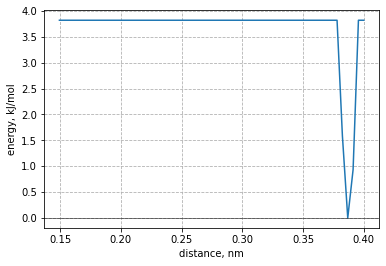

In [21]:
import pandas as pd
df = pd.read_csv("awh_t0.1.xvg", sep='\s+', header=26, names=['distance','energy'])
mine = min(df[['energy']].to_numpy()[10:])
df['energy'] -= mine
ax = df.plot('distance',xlabel='distance, nm', ylabel='energy, kJ/mol', legend=False)
ax.grid(True, which='both', linestyle='--')
ax.axhline(y=0, color='k', linewidth=0.5)

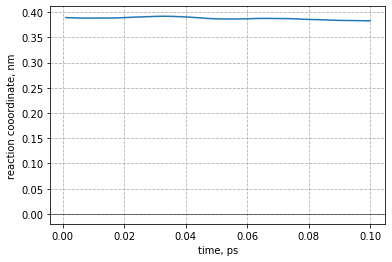

In [22]:
import pandas as pd
df = pd.read_csv("pullx.xvg", sep='\s+', header=17, names=['time','distance'])
ax = df.plot('time',xlabel='time, ps', ylabel='reaction cooordinate, nm', legend=False)
ax.grid(True, which='both', linestyle='--')
ax.axhline(y=0, color='k', linewidth=0.5)

Not much changed in 100 fs, free-energy has only a small well now. But check how it looks after 35 ps simulation:

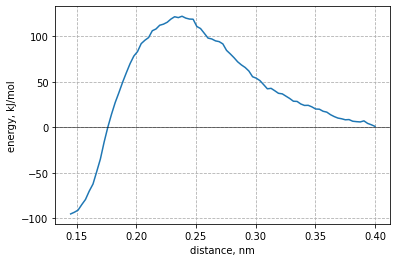

In [53]:
import pandas as pd
df = pd.read_csv(rdir + "/reference-data/DA-awh/awh_t35.xvg", sep='\s+', header=30, names=['distance','energy','bias','distribution','distribution1','distribution2','distribution3','distribution4'])
mine = min(df[['energy']].to_numpy()[10:])
df['energy'] -= mine
ax = df.plot(x='distance',y='energy',xlabel='distance, nm', ylabel='energy, kJ/mol', legend=False)
ax.grid(True, which='both', linestyle='--')
ax.axhline(y=0, color='k', linewidth=0.5)

Check also distribution of the reaction cooordinate across whole interval. line `y=1` is a level towards which AWH pushes distribution with bias:

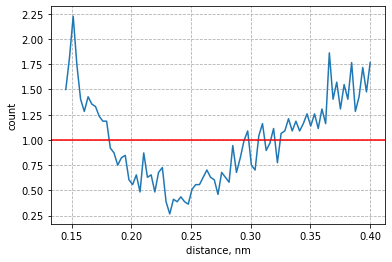

In [62]:
import pandas as pd
df = pd.read_csv(rdir + "/reference-data/DA-awh/awh_t35.xvg", sep='\s+', header=30, names=['distance','energy','bias','distribution','distribution1','distribution2','distribution3','distribution4'])
ax = df.plot(x='distance',y='distribution',xlabel='distance, nm', ylabel='count', legend=False)
ax.grid(True, which='both', linestyle='--')
ax.axhline(y=1, color='r', linewidth=1.5)

In addition, to be sure about quality of generated profile, you should see repeating transitions of the reaction coordinate between products and reagents and back at the end of AWH trajectory:

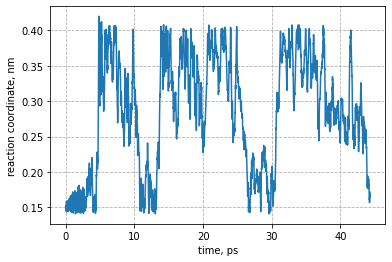

In [64]:
import pandas as pd
df = pd.read_csv(rdir + "/reference-data/DA-awh/pullx35.xvg", sep='\s+', header=17, names=['time','coor'])
ax = df.plot('time',xlabel='time, ps', ylabel='reaction coordinate, nm', legend=False)
ax.grid(True, which='both', linestyle='--')

Finally lets compare all obtained profiles:

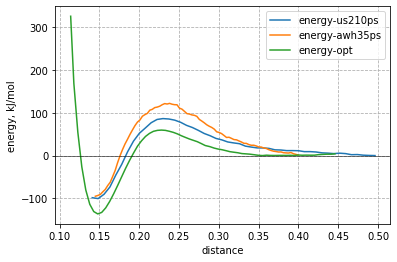

In [57]:
import pandas as pd
dfus = pd.read_csv(rdir + "/reference-data/DA-us/profile10ps.xvg", sep='\s+', header=17, names=['distance','energy-us210ps'])
mine = min(dfus[['energy-us210ps']].to_numpy()[10:])
dfus['energy-us210ps'] -= mine
ax = dfus.plot('distance',xlabel='distance, nm', ylabel='energy, kJ/mol')

dfawh = pd.read_csv(rdir + "/reference-data/DA-awh/awh_t35.xvg", sep='\s+', header=30, names=['distance','energy-awh35ps','bias','distribution','distribution1','distribution2','distribution3','distribution4'])
mine = min(dfawh[['energy-awh35ps']].to_numpy()[10:])
dfawh['energy-awh35ps'] -= mine
dfawh.plot('distance','energy-awh35ps', ax=ax)

dfopt = pd.read_csv(rdir + "/reference-data/DA-opt/rsurf.xvg", sep='\s+', header=None, names=['distance','energy-opt'])
mine = min(dfopt[['energy-opt']].to_numpy()[20:])
dfopt['energy-opt'] -= mine
dfopt.plot('distance', ax=ax)

ax.grid(True, which='both', linestyle='--')
ax.axhline(y=0, color='k', linewidth=0.5)

As you may notice AWH profile after 35 ps is already very close to the umbrella sampling result obtained from 210 ps (21 frame * 10 ps) total simulations! That could save you a lot of computing resources when used wisely.